### Install missing packages to kernel...


In [267]:
! pip install pandas
! pip install scikit-learn
! pip install numpy
! pip install scipy
! pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import packages...

In [484]:
# import pandas
import pandas as pd 
# Set maximimum display width to none... (so we can look at entire tweets)
pd.options.display.max_colwidth = None

# import numpy
import numpy as np

# import csr_matrix from scipy.parse
from scipy.sparse import csr_matrix

# import CountVectorizer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer

# import normalize from sklearn.preprocessing
from sklearn.preprocessing import normalize

# import KMeans from sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import pdist, squareform
import scipy.sparse as sp

# import cosine_similarity from sklearn.metrics.pairwise
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import silhouette_score

# import matplotlib.pyplot
import matplotlib.pyplot as plt

# CSDS-435: Project #2
# Adam Brennan and Charlie Song

## Helper Functions...

In [180]:
def get_cnn_health_tweets_dataframe():
    # read in the cnnhealth.txt file using utf-8 encoding
    with open('cnnhealth.txt', 'r', encoding='utf-8') as cnn_health_tweets_dataset:
        # initialize empty list to store tweets
        tweets = []

        # for each row in the dataset, skip the first two columns and append the tweet to the tweets list
        for row in cnn_health_tweets_dataset:
            columns = row.strip().split('|')
            tweet = '|'.join(columns[2:])
            tweets.append([tweet])

    # convert list of tweets to pandas DataFrame
    df = pd.DataFrame(tweets, columns=['tweet'])
    
    # return the resulting pandas DataFrame
    return df

In [236]:
def get_bag_of_words_matrix(tweets_list, binary = False, output_to_file = False):
    # initialize CountVectorizer opbject 
    vectorizer = CountVectorizer(binary = binary)

    # build bag of words matrix from tweets list
    bag_of_words_matrix = vectorizer.fit_transform(tweets_list)

    # if output_to_file is set to true
    if(output_to_file):
        # output the bag of words matrix to a .txt file
        bag_of_words_matrix_csr = csr_matrix(bag_of_words_matrix)
        bag_of_words_matrix_array = bag_of_words_matrix_csr.toarray() 
        np.savetxt("bag_of_words_matrix.txt", bag_of_words_matrix_array, fmt="%d", delimiter=" ")
    
    # return the bag of words matrix
    return bag_of_words_matrix

In [182]:
def get_bag_of_words_dataframe(tweets_list):
    # initialize CountVectorizer opbject 
    vectorizer = CountVectorizer()

    # build bag of words matrix from tweets list
    bag_of_words_matrix = vectorizer.fit_transform(tweets_list)

    # convert bag of words matrix to a pandas DataFrame
    bag_of_words_df = pd.DataFrame(bag_of_words_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    
    # return the bag of words dataframe
    return bag_of_words_df

In [163]:
def get_tweet(tweets_df, tweet_index):
    # return the tweet at the specified index in string form
    return str(tweets_df.iloc[tweet_index])

In [184]:
def get_tweets_summary_dataframe(tweets_list):
    # get the total number of tweets by getting the length of the tweets list
    num_tweets = len(tweets_list)
    # get the bag of words dataframe for the tweets list
    bag_of_words_dataframe = get_bag_of_words_dataframe(tweets_list)
    # get number of total tokens by counting nonzeros in the dataframe
    num_total_tokens = np.count_nonzero(bag_of_words_dataframe)
    # get number of unique tokens by getting column count of the dataframe
    num_unique_tokens = bag_of_words_dataframe.shape[1]
    # get average number of tokens per tweet by diving the total number of tokens by the number of tweets
    num_avg_tokens_per_tweet = num_total_tokens / num_tweets

    # create the DataFrame object
    row = [['CNN Health Tweets', num_tweets, num_total_tokens, num_unique_tokens, num_avg_tokens_per_tweet, 'A dataset containing tweets pertaining to health from CNN.']]
    columns = ['Dataset Name', '# Tweets', '# Total Tokens', '# Unique Tokens', 'Avg. Tokens Per Tweet', 'Description']
    tweets_summary_dataframe = pd.DataFrame(row, columns=columns)
    
    # return the created DataFrame
    return tweets_summary_dataframe

In [251]:
def get_cosine_similarity(bag_of_words_matrix, output_to_file = False):
    # get the cosine similarities from the bag of words matrix
    bag_of_words_matrix_cs = 1 - cosine_similarity(bag_of_words_matrix)

    # if output_to_file is set to true, save the matrix to a .txt file
    if(output_to_file):
        np.savetxt("cosine_similarity.txt", bag_of_words_matrix_cs, delimiter=',', fmt='%.2f')

    # return the cosine similarities
    return bag_of_words_matrix_cs

In [304]:
def get_jaccard_similarity(tweets_list, output_to_file = False):
    bag_of_words_matrix = get_bag_of_words_matrix(tweets_list, binary = True)

    bag_of_words_matrix_js = squareform(pdist(bag_of_words_matrix.toarray(), metric="jaccard"))

    # if output_to_file is set to true, save the matrix to a .txt file
    if(output_to_file):
        np.savetxt("jaccard_similarity.txt", bag_of_words_matrix_js, delimiter=',', fmt='%.2f')
    
    return bag_of_words_matrix_js

In [223]:
def estimate_number_of_clusters_using_elbow_method(start, end, bag_of_words_matrix):
    inertia = []
    for k in range(start, end):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(bag_of_words_matrix)
        inertia.append(kmeans.inertia_)

    plt.plot(range(start, end), inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

In [303]:
def get_histogram_of_distance_measure(distance_measures_matrix, xlabel, ylabel, title):
    distance_measures_matrix = distance_measures_matrix[np.triu_indices_from(distance_measures_matrix, k=1)]

    plt.hist(distance_measures_matrix, bins=10, edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [419]:
def get_histogram_of_clusters(clusters_dataframe, title):
    label_counts = clusters_dataframe.groupby('label').count()
    plt.figure(figsize=(8, 5))
    label_counts.plot(kind='bar', color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

In [485]:
def get_silhouette_score(bag_of_words_distance_matrix, labels):
    sc = silhouette_score(bag_of_words_distance_matrix, labels, metric='precomputed')

    return sc
    

## I. (10pts) parse it and construct feature vectors using bag-of-words, output result to a file, and generate summary statistics;

### Reading in the "cnnhealth.txt" file...

In [167]:
# get pandas DataFrame
tweets_df = get_cnn_health_tweets_dataframe()

# display DataFrame
tweets_df

,tweet
0,"An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv"
1,A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg
2,It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk
3,RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN http://cnn.it/1GNdmqc https://t.co/…
4,RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…
...,...
4056,RT @EverydayHealth: Want killer abs? @JillianMichaels shows you how get them: http://at.cnn.com/ubAkAN
4057,Medicare at stake -- @sanjayguptaCNN talks about politicians' plans http://at.cnn.com/7nLSOm7
4058,Ann Romney talks about her experience with MS http://at.cnn.com/khb6keC
4059,Make sure your first marathon isn't your last! http://at.cnn.com/liehiPl


### Get tweet as list...

In [168]:
# get list of tweets
tweets_list = tweets_df['tweet'].tolist()

tweets_list

['An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv',
 'A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg',
 "It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk",
 'RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN  http://cnn.it/1GNdmqc https://t.co/…',
 'RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…',
 'Maysoon Zayid, a touring standup comic with Cerebral Palsy, has a message to share. http://cnn.it/1GNiH0L http://pbs.twimg.com/media/B__ubV_UQAAUNOO.jpg',
 "How women can wipe out Alzheimer's, from @mariashriver.  http://cnn.it/1AklXJQ http://pbs.twimg.com/medi

In [171]:
bag_of_words_matrix = get_bag_of_words_matrix(tweets_list, output_to_file = True)

### Get the "bag of words" pandas DataFrame using the previously generated tweets pandas DataFrame...

In [172]:
# generate "bag of words" pandas DataFrame
bag_of_words_dataframe = get_bag_of_words_dataframe(tweets_list)

# display "bag of words" pandas DataFrame
bag_of_words_dataframe

,000,008relo,00fvvdw,00igyua,01,01tdt1o,02,03,04,05,...,zwwtu7,zxodiqo,zy53fec,zy7u11,zyam2xi,zyl,zyt5bpe,zzetat,zzgrrgf,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get the tweets summary DataFrame...

In [189]:
# generate "bag of words" pandas DataFrame
tweets_summary_dataframe = get_tweets_summary_dataframe(tweets_list)

# display resulting pandas DataFrame
tweets_summary_dataframe

,Dataset Name,# Tweets,# Total Tokens,# Unique Tokens,Avg. Tokens Per Tweet,Description
0,CNN Health Tweets,4061,69498,11264,17.113519,A dataset containing tweets pertaining to health from CNN.


## II. (10pts) construct  two distant measures, output results to two files, and generate histogram of the two distances;  

### Distance measure #1: Cosine Similarity

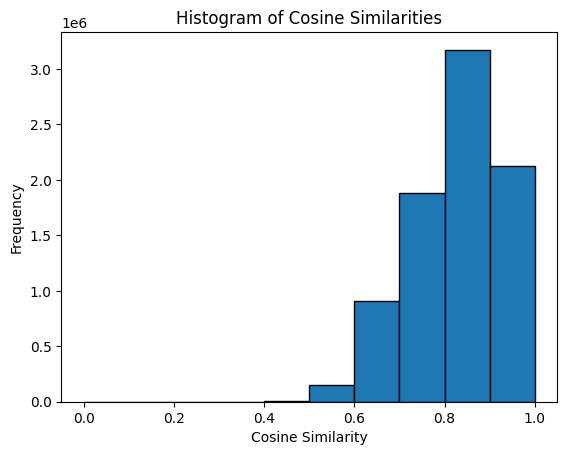

In [487]:
bag_of_words_matrix = get_bag_of_words_matrix(tweets_list)

bag_of_words_matrix_cs = get_cosine_similarity(bag_of_words_matrix, output_to_file = True)

get_histogram_of_distance_measure(bag_of_words_matrix_cs, 'Cosine Similarity', 'Frequency', 'Histogram of Cosine Similarities')

### Distance measure #2: Jaccard Similarity

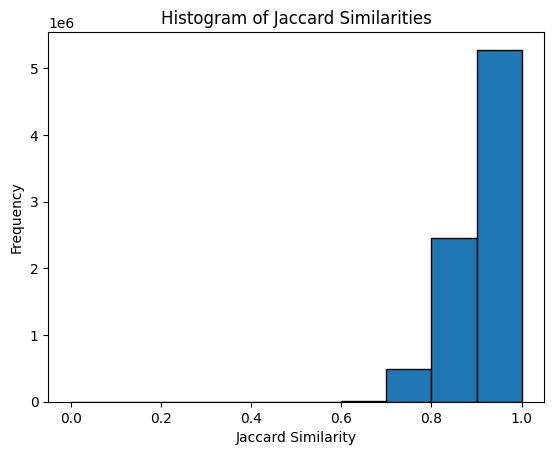

In [306]:
bag_of_words_matrix_js = get_jaccard_similarity(tweets_list)

get_histogram_of_distance_measure(bag_of_words_matrix_js, 'Jaccard Similarity', 'Frequency', 'Histogram of Jaccard Similarities')

## III. (20pts) implement 4 clustering algorithms (5pts for each method),

### Estimating the number of clusters using the elbow method...

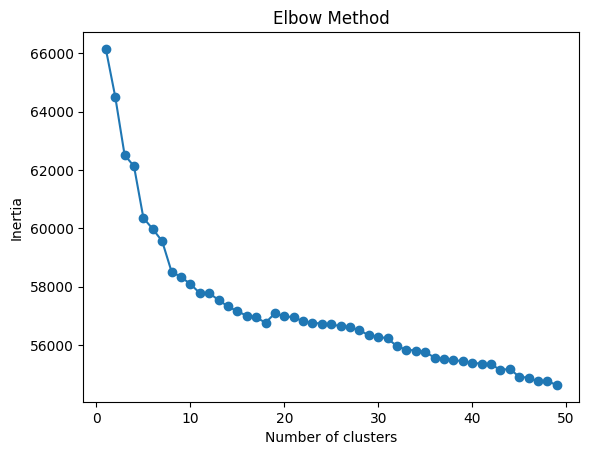

In [257]:
estimate_number_of_clusters_using_elbow_method(1, 50, bag_of_words_matrix)

In [270]:
num_clusters = 7

### Clustering using KMeans...

#### First cluster with cosine similarity as the distance measure...

In [515]:
bow = get_bag_of_words_matrix(tweets_list)
normalized_bow = normalize(bow, norm='l2', axis=1)

kmeans = KMeans(n_clusters = 7, random_state = 0)
kmeans.fit(normalized_bow)

labels = kmeans.labels_
labels

array([5, 6, 5, ..., 2, 2, 2], dtype=int32)

In [516]:
df = pd.DataFrame({
    'tweets': tweets_list,
    'label': labels
})

df[df['label'] == 0]

,tweets,label
19,RT @CNNMoney: This computer can diagnose cancer. Watch: http://cnnmon.ie/1GKz7qP CC @enlitic @jeremyphoward By @jillianeugenios http://t.co/V…,0
21,RT @TIME: The hidden dangers of being ‘skinny fat’ http://ti.me/1Gvz26A,0
33,RT @CNNMoney: Tyson shares dropped after officials confirmed cases of bird flu in the U.S. http://cnnmon.ie/1HEyDAd $TSN http://t.co/Yv53Kw10…,0
38,Brilliant flu-risk map by @EverydayHealth: Enter your zip code and learn your #flu risk http://bit.ly/1ymrovI,0
40,RT @milesobrien: Thanks to @drsanjaygupta @roniselig @susanchun1 @tinkertime @calebhell @AC360 for such a powerful film. I hope this teache…,0
...,...,...
3863,RT @TIMEHealthland: Can caring for aging parents hurt your career and paycheck? | http://ti.me/PZqHiO,0
3899,"RT @CNNFitNation: Race weekend pics are up! Check out the team, @sanjayguptaCNN &amp; @chrissiesmiles racing! http://on.fb.me/Psvp8z",0
3907,RT @DanielleCNN: Happy happy birthday @ElizCohenCNN!! xo http://instagr.am/p/PxDJdyBKAO/,0
4015,Happy Labor Day! What are you doing to stay healthy this weekend?,0


In [517]:
df.groupby('label').count()

,tweets
label,
0,711
1,266
2,1167
3,310
4,404
5,918
6,285


<Figure size 800x500 with 0 Axes>

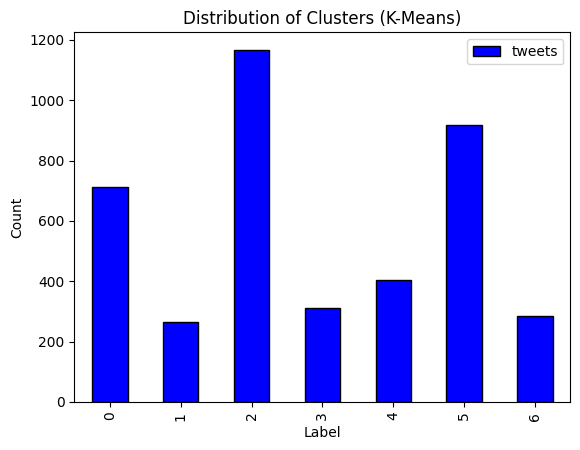

In [518]:
get_histogram_of_clusters(df, 'Distribution of Clusters (K-Means)')

In [521]:
silhouette_avg = silhouette_score(normalized_bow, labels, metric='cosine')

silhouette_avg

np.float64(0.04378550827403861)

### Clustering using Hierarhical Clustering...

#### First cluster with jaccard similarity as the distance measure...

In [522]:
agglomerative = AgglomerativeClustering(n_clusters=num_clusters, metric="precomputed", linkage="average")
labels = agglomerative.fit_predict(bag_of_words_matrix_js)

df = pd.DataFrame({
    'tweets': tweets_list,
    'label': labels
})

In [523]:
df.groupby('label').count()

,tweets
label,
0,47
1,37
2,25
3,3
4,3943
5,2
6,4


<Figure size 800x500 with 0 Axes>

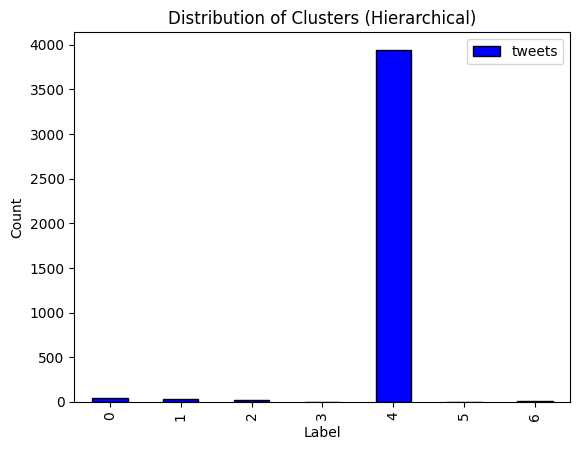

In [524]:
get_histogram_of_clusters(df, 'Distribution of Clusters (Hierarchical)')

In [525]:
df[df['label'] == 1]


,tweets,label
249,.@Erinannie11674 Scientists believe #Ebola survivors have antibodies that protect them from becoming infected again #EbolaQandA,1
251,".@SKGross2009 If the vaccine isn't properly tested, it could have neg. side effects. Vaccines generally given to healthy ppl #EbolaQandA",1
255,"@bjhavejoy55 Yes you can, if he was contagious at the time #EbolaQandA",1
256,".@elizabethrydan Family released his name, not the hospital or @CDCgov. HIPPA prevents health care workers from doing so #EbolaQandA",1
257,.@Jayteee420 Docs talking w/ him about options (ZMapp or other experimental drug TKM-Ebola) He could say no as drugs not proven #EbolaQandA,1
...,...,...
299,. @codexman Anyone leaving affected countries is being screened -- temp taken at airport. But entry into U.S. is another story #EbolaQandA,1
301,.@Freckles7682 No. Didn't have symptoms until 4d after landed in U.S. Virus only spreads when sick More: http://cnn.it/1uzKHzc #EbolaQandA,1
302,.@sophiapawlowski Good Q. @DrFriedenCDC said he's confident but this new patient was contagious in the community for four days #EbolaQandA,1
1366,@ChantalMazza @MyTrainerBob Good q -- without that info it's hard to really know if she's underweight,1


In [526]:
k_means_sc = get_silhouette_score(bag_of_words_matrix_js, labels)

k_means_sc

np.float64(0.06726215298327776)

### Clustering using DBSCAN...

#### First cluster with jaccard similarity as the distance measure...

In [ ]:
dbscan = DBSCAN(eps=0.72, min_samples=4, metric="precomputed")
labels = dbscan.fit_predict(bag_of_words_matrix_js)

df = pd.DataFrame({
    'tweets': tweets_list,
    'label': labels
})

In [546]:
df.groupby('label').count()

,tweets
label,
-1,1501
0,2447
1,3
2,16
3,4
...,...
15,4
16,3
17,5


<Figure size 800x500 with 0 Axes>

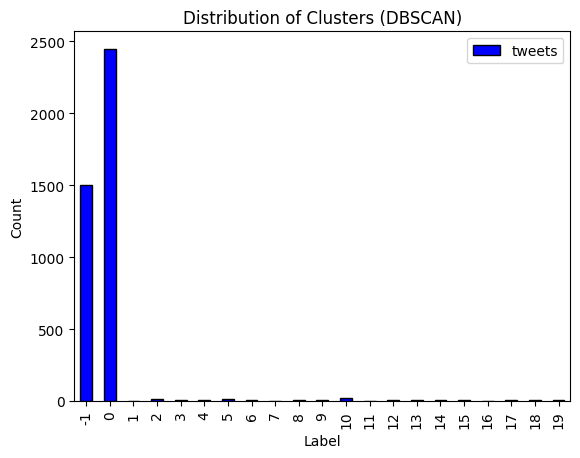

In [547]:
get_histogram_of_clusters(df, 'Distribution of Clusters (DBSCAN)')

In [548]:
df[df['label'] == 1]

,tweets,label
243,Madrid euthanizes #ebola patient's dog: http://cnn.it/1sc9RBJ,1
450,Borders closing over #Ebola fears http://cnn.it/1whsoQR,1
553,Secret serum likely saved American #Ebola patient http://cnn.it/1pToQeS,1


In [549]:
k_means_sc = get_silhouette_score(bag_of_words_matrix_js, labels)

k_means_sc

np.float64(-0.015381426061589546)

### Clustering using EM Clustering...

#### First cluster with euclidean distance as the distance measure...

#### First cluster with cosine similarity as the distance measure...